## Exercise in Photogrammetry II
# Ex. 02 Essential Matrix
### Submission: xx.xx.xxxx 
### Points: 12

In this exercise you will learn how to estimate the essential matrix given two images. You are given two images ```0400.jpg``` and ```0840.jpg```, and a set of point correspondences stored in the file ```x1x2.mat```. Here x1 denotes the pixel coordinates in the first image and x2 the pixel coordinates in the second image. Additionally, we provide the interior camera parameters **K**. 

**DATA:** Extract the data from the provided zip file with the password: photo

[[522   0 300]
 [  0 522 240]
 [  0   0   1]]


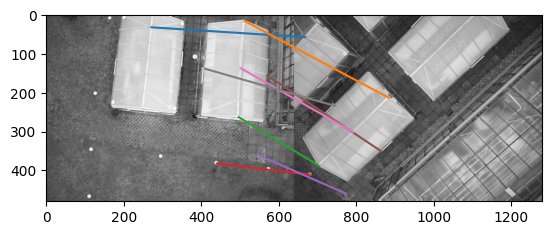

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image
import scipy.io
import numpy as np
import matplotlib.image

K = np.array([[522,0,300],
                [0,522,240],
                [0,0,1]])
print(K)
pts1 = scipy.io.loadmat("./data/x1x2.mat")["x1"]
pts2 = scipy.io.loadmat("./data/x1x2.mat")["x2"]


img1 = matplotlib.image.imread("./data/0400.jpg")
img2 = matplotlib.image.imread("./data/0840.jpg")
I = np.hstack([img1,img2])
plt.imshow(I,cmap='gray')
for i in range(pts1.shape[0]):
    plt.plot([pts1[i,1],pts2[i,1]+img1.shape[1]],[pts1[i,0],pts2[i,0]],'-')

## A Essential matrix and relative orentation

**Tasks:**

1. How many point correspondences do you need at least for computing the essential matrix? Give reasons for your answer. (1 Point)
2. What should one pay attention to when selecting point correspondences? Give reasons for your answer. (1 Point)
3. Specify all steps needed to estimate the essenetial matrix from two images. (2 Points)
4. {Code} Write a function that computes the essential matrix $E$ using the 8-point algorithm presented in the lecture. Test your function for the given correspondences. Print out the essential matrix $E$ as well as its rank. You don't need to normalize the data in this exercise.(4 Points)
5. {Code} Estimate the rotation $R$ and translation $b$ of the second camera with respect to the first camera. Use the provided function ```triangulatePoints(...)``` (in utils.py) to test for which solutions of $R$ and $b$ all points are in front of both cameras. Print out the results of $R$ and $b$. (6 Points)

1. In order to compute the essential matrix I need at least 8 points for the 8-point algorithm, and at least 5 points for the 5-point algorithm. That's due to the amount of degrees of freedom. For the 8-point algorithm I don't know the calibration, for the 5-point algorithm I just don't know the relative orientation and translation (without scale).
2. The most important thing to pay attention to when selecting point correspondences is to get rid of outliers, otherwise our algorithm won't work at all, it is also important to pick points that are not laying on the same plane, to avoid numerical instability.
3. In order to estimate the essential matrix $E$ from two images I need to first find the corresponding points. Either 8 or 5 for 8-point or 5-point algorithm. For 8-point algorithm I then create my coefficients matrix where each row is the Kronecker product of corresponding 2 points in homogeneous coordinates. I then use the singular value decomposition, and from the right singular matrix I take the last vector which corresponds to the smallest singular value and reshape that into 3x3 matrix. This 3x3 matrix I then decompose again using SVD, and this time I modify the smallest singular value in the middle singular matrix by changing it to 0, essentially guaranteeing the rank deficiency from 3 to 2, and my essential matrix is now a product of the 3 matrices from SVD including my modified one. For the 5-point algorithm I solve a polynomial of degree 10, I then use RANSAC + evaluate the solutions to pick the physically viable one.

In [2]:
# 4.

# Allocate coefficients matrix.
coefficients_matrix = np.zeros((len(pts1), 9))

# Fill the coefficients matrix.
for i in range(len(pts1)):
    coefficients_matrix[i] = np.kron(pts2[i], pts1[i])

# Perform first SVD.
_, _, Vt = np.linalg.svd(coefficients_matrix)

# Collect the vector corresponding to smallest singular value in the form of 3x3.
E = np.reshape(Vt[-1], (3, 3)) 

# Perform second SVD.
U, S, Vt = np.linalg.svd(E)

# Modify the singular values matrix.
S[2] = 0
S = np.diag(S)

# Construct essential matrix from the modified second SVD elements.
E = U @ S @ Vt

print(E)

[[ 7.82814444e-07  1.40937258e-06  3.88274919e-03]
 [-3.93065833e-07 -5.35827175e-07  1.50840206e-03]
 [-2.85538678e-03 -4.38730712e-03  9.99977623e-01]]


## Perform tests for essential matrix correctnes.

In [3]:
# Rank should be 2.
print(np.linalg.matrix_rank(E))

2


In [4]:
# Epipolar constraint e''Fe'T should be close to zero.
for i in range(len(pts1)):
    print(pts2[i] @ E @ pts1[i].T)

-2.6639896592239865e-05
-0.0010434208100154052
7.019416445741555e-05
-0.0001765660141175296
-2.9461917248063685e-06
-0.000439631385135808
-0.0001887286893555995
-6.453758584568092e-05


In [5]:
# Singular values should be approximately [s, s, 0].
_, S, _ = np.linalg.svd(E)
print(S)

[1.00000000e+00 2.30950934e-05 1.65016439e-19]


In [6]:
# Determinant should be close 0.
print(np.linalg.det(E))

-2.0464756075765628e-27


In [23]:
# 5.

# Decompose the essential matrix using SVD.
U, _, Vt = np.linalg.svd(E)

# Define Z and W used to find 4 permutations of Sb and R.
Z = np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 0]])
W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])

# Find 2 different Sb's and 2 different R's.
Sb_1 = U @ Z @ U.T
Sb_2 = U @ Z.T @ U.T
R_1 = U @ W @ Vt
R_2 = U @ W.T @ Vt

# Find 2 different b's from Sb's.
b_1 = np.array([Sb_1[2, 1], Sb_1[0, 2], Sb_1[1, 0]])
b_2 = np.array([Sb_2[2, 1], Sb_2[0, 2], Sb_2[1, 0]])

# Test with function given by the tutor.
from utils_ex11.utils import triangulate_points

X1 = triangulate_points(pts1, pts2, K, R_1, b_1)
X2 = triangulate_points(pts1, pts2, K, R_1, b_2)
X3 = triangulate_points(pts1, pts2, K, R_2, b_1)
X4 = triangulate_points(pts1, pts2, K, R_2, b_2)

In [24]:
# Transform all given points X to be represented in second camera's coordinate frame.
def transform_points(X, R, b):

    # Construct homogeneous transformation matrix from given rotation and translation.
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = b

    # Find the inverse which represents transformation world->second camera.
    T_inv = np.linalg.inv(T)

    # Represent points in the world in homogeneous coordinates.
    X_homo = np.hstack((X, np.ones((len(X), 1))))

    # Transform points from world to the second camera coordinate frame.
    X_transformed = np.dot(T_inv, X_homo.T)

    return X_transformed.T

In [26]:
# Transform all points to the 2nd camera coordinate frame.
X1_cam2 = transform_points(X1, R_1, b_1)
X2_cam2 = transform_points(X2, R_1, b_2)
X3_cam2 = transform_points(X2, R_2, b_1)
X4_cam2 = transform_points(X2, R_2, b_2)

# Print global (camera 1) + camera 2 coordinate frames and see where all points are in front (positive Z).
print(f'R1, b1:\n{X1}\n{X1_cam2}')
print(f'R1, b2:\n{X2}\n{X2_cam2}')
print(f'R2, b1:\n{X3}\n{X3_cam2}')
print(f'R2, b2:\n{X4}\n{X4_cam2}')

R1, b1:
[[-0.13499698  0.49042243  0.12931546]
 [-0.28205762  0.58427175  0.21288699]
 [-0.23540594  0.50920942  0.15456555]
 [-0.25079077  0.41594508  0.04607238]
 [-0.21877744  0.50326361  0.1580577 ]
 [-0.27395741  0.59974467  0.23598844]
 [-0.25603867  0.56700408  0.20704875]
 [-0.20904353  0.52997145  0.16896226]]
[[ 0.48389657 -0.15722011 -0.02414678  1.        ]
 [ 0.41491078 -0.01464508  0.08690298  1.        ]
 [ 0.45566792 -0.11001519  0.06556005  1.        ]
 [ 0.46713567 -0.24691818  0.10835912  1.        ]
 [ 0.46675564 -0.11284516  0.05166371  1.        ]
 [ 0.41725777  0.01145826  0.0745819   1.        ]
 [ 0.43248837 -0.03269004  0.06754708  1.        ]
 [ 0.45398508 -0.09145745  0.03415811  1.        ]]
R1, b2:
[[ 0.13499698 -0.49042243 -0.12931546]
 [ 0.28205762 -0.58427175 -0.21288699]
 [ 0.23540594 -0.50920942 -0.15456555]
 [ 0.25079077 -0.41594508 -0.04607238]
 [ 0.21877744 -0.50326361 -0.1580577 ]
 [ 0.27395741 -0.59974467 -0.23598844]
 [ 0.25603867 -0.56700408 -0

There seems to be something wrong, because in two cases: R1b1 and R2b1 there seems to be 1 point thats behind the second camera. I'm not sure what went wrong. But considering those results look like something was normalized (input data?), and if we ignore the bug with that 1 point being behind 2nd camera, I'd choose R1b1, because in R2b1 we can see that the whole X-axis goes well beyond 1.0 (and I would assume in normalized scenario we stay between -1.0 and 1.0).  

My answer: R1b1.